In [3]:
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
import pyvisa

import datetime
from timeit import default_timer as timer

from E5063A import *

In [4]:
# List the resources connected
rm = pyvisa.ResourceManager()
rm.list_resources()

('GPIB0::17::INSTR',)

In [11]:
# Parameters

vna_address = 'GPIB0::17::INSTR' # Address to VNA
                                 # Run cell above to find address if needed

save_data = 1
save_file_name = 'RT_ESRes4_hf-s20-f3.csv' # The date and time is automatically added as a prefix


if_bandwidth = 7e3  # Hz, IF-Bandwidth

start_freq = 4e9 # Hz, Start Frequency 
stop_freq = 8e9 # Hz, Stop Frequency
meas_span = 100e6 # Hz, Span of each Frequency Sweep
num_points = 1001 # Hz, Number of Points in each Frequency Sweep

s = 'S12' # S-parameter to measure
s_format = 'PLOG' # Data Format
                  # PLOG for log magnitude and phase
                  # PLin for lin magnitude and phase
                  # MLOG for lin magnitude
                  # MLIN for linear magnetude

In [12]:
# Connect to the VNA
rm = pyvisa.ResourceManager()
vna = rm.open_resource(vna_address)

# Query the VNA's identification
idn = vna.query('*IDN?')
print(f'VNA being used: {idn}')

vna.close()

VNA being used: Keysight Technologies,E5063A,MY54502588,A.07.00



In [13]:
# Prepare for the measurement
freq_spacing = meas_span/(num_points-1) # Frequency spacing
num_meas = np.floor((stop_freq - start_freq)/meas_span) # Number of measurement sweeps that will be performed

# Configure VNA
config_start_stop_freq(vna_address, start_freq, stop_freq)
config_vna(vna_address, s, s_format, num_points, if_bandwidth) 

# Get VNA configuration
vna_config = get_vna_config(vna_address)
print(f'IF Bandwidth: {vna_config[3]:.3f} Hz')
print(f'Power Level: {vna_config[4]:.3f} dB')
print('---')
print(f'Start Frequency: {vna_config[0]/1e9:.5f} GHz')
print(f'Stop Frequency: {vna_config[1]/1e9:.5f} GHz')
print(f'Number of Measurements: {num_meas}')
print(f'Number of Points per measurement: {vna_config[2]:.0f}')
print(f'Frequency Spacing: {freq_spacing/1e6} MHz')

IF Bandwidth: 7000.000 Hz
Power Level: -20.000 dB
---
Start Frequency: 4.00000 GHz
Stop Frequency: 8.00000 GHz
Number of Measurements: 40.0
Number of Points per measurement: 1001
Frequency Spacing: 0.1 MHz


Text(0.5, 0, 'Frequency (GHz)')

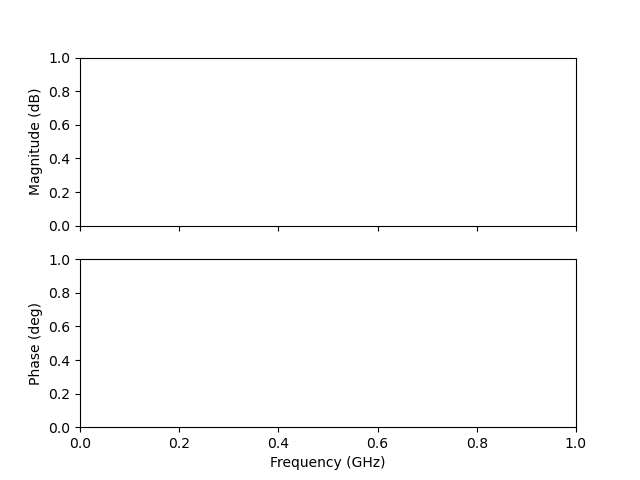

In [14]:
# Generate figure for performing and stitching measurements

plt.ion()
fig = plt.figure(dpi=100)
(ax1, ax2) = fig.subplots(2,1,sharex=1)
ax1.set_ylabel('Magnitude (dB)')
ax2.set_ylabel('Phase (deg)')
ax2.set_xlabel('Frequency (GHz)')

In [15]:
# Perform and stitch measurements

# Cumulative data arrays
freq = []
mag = []
phase = []

today = str(datetime.date.today())
now = datetime.datetime.now()
current_time = now.strftime("%H-%M-%S")
save_file = today + '_' + current_time + '_stitched_s.csv'

# Start and stop frequencies for the i'th measurement
start_freqi = start_freq
stop_freqi = start_freqi + meas_span

for i in np.arange(num_meas):
    start_time = timer()
    freqi, magi, phasei = measure_s_ss(vna_address, start_freqi, stop_freqi) # Perform measurement
    
    # Append the measurement data to the cumulative data arrays
    freq = np.append(freq, freqi) 
    mag = np.append(mag, magi)
    phase = np.append(phase, phasei)

    if save_data == 1:
        save_s(freq, mag, phase, save_file) # Save data
    
    end_time = timer()
    loop_time = end_time - start_time
    remaining_time = (num_meas - (i+1))*loop_time
    meas_info = str(f'Measurement {i+1:3.0f}: {start_freqi/1e9:.6f} to {stop_freqi/1e9:.6f} GHz')
    time_info = str(f'Remaining Time: {remaining_time:.2f} secs')
    info = meas_info+'\n'+time_info
    print(f'Loop Time: {loop_time} secs')
    print(info)

    # Plot data
    ax1.clear()
    ax1.plot(freq/1e9, mag)
    ax1.set_ylabel('Magnitude (dB)')
    
    ax2.clear()
    ax2.plot(freq/1e9, phase)
    ax2.set_ylabel('Phase (deg)')
    ax2.set_xlabel('Frequency (GHz)')

    #fig.suptitle(info)

    fig.canvas.draw()
    
    # Update start and stop frequencies for the next loop
    start_freqi = stop_freqi + freq_spacing
    stop_freqi += meas_span


Loop Time: 1.0403149000001122 secs
Measurement   1: 4.000000 to 4.100000 GHz
Remaining Time: 40.57 secs
Loop Time: 1.0743941999999151 secs
Measurement   2: 4.100100 to 4.200000 GHz
Remaining Time: 40.83 secs
Loop Time: 1.0471196999999393 secs
Measurement   3: 4.200100 to 4.300000 GHz
Remaining Time: 38.74 secs
Loop Time: 1.0256482000002052 secs
Measurement   4: 4.300100 to 4.400000 GHz
Remaining Time: 36.92 secs
Loop Time: 1.023746699999947 secs
Measurement   5: 4.400100 to 4.500000 GHz
Remaining Time: 35.83 secs
Loop Time: 1.0336105999999745 secs
Measurement   6: 4.500100 to 4.600000 GHz
Remaining Time: 35.14 secs
Loop Time: 1.0359365000001617 secs
Measurement   7: 4.600100 to 4.700000 GHz
Remaining Time: 34.19 secs
Loop Time: 1.0254460999999537 secs
Measurement   8: 4.700100 to 4.800000 GHz
Remaining Time: 32.81 secs
Loop Time: 1.0282181999998556 secs
Measurement   9: 4.800100 to 4.900000 GHz
Remaining Time: 31.87 secs
Loop Time: 1.0322077000000718 secs
Measurement  10: 4.900100 to 5

KeyboardInterrupt: 